In [ ]:
#%% Import and load/process data

from medmnist import BloodMNIST
import os
import deeptrack as dt
import torch
import numpy as np
import deeplay as dl
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from PIL import Image
from deeptrack.sources import Source, Join
from matplotlib.patches import Rectangle
import glob

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\deeptrack\__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


In [ ]:
#%%

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")

def rgb_to_grayscale(tensor):
    r, g, b = tensor[:, :, 0], tensor[:, :, 1], tensor[:, :, 2]
    return 0.2989 * r + 0.5870 * g + 0.1140 * b

# Load BloodMNIST data
BloodMNIST_train_dataset = BloodMNIST(split="train", download=True)
BloodMNIST_test_dataset = BloodMNIST(split="test", download=True)

# Convert to float tensors
train_imgs = torch.tensor(BloodMNIST_train_dataset.imgs).float()
test_imgs = torch.tensor(BloodMNIST_test_dataset.imgs).float()

# Convert to grayscale
train_gray = torch.stack([rgb_to_grayscale(img) for img in train_imgs])
test_gray = torch.stack([rgb_to_grayscale(img) for img in test_imgs])

# Save grayscale images to disk
def save_tensor_as_images(tensor, folder_path):
    os.makedirs(folder_path, exist_ok=True)
    
    if not os.listdir(folder_path):
        for i, img_tensor in enumerate(tensor):
            img = Image.fromarray(img_tensor.numpy().astype('uint8'))
            img.save(os.path.join(folder_path, f"{i}.png"))
    else:
        print(f"Images already exist in {folder_path}, skipping saving")

save_tensor_as_images(train_gray, "bloodmnist/train")
save_tensor_as_images(test_gray, "bloodmnist/test")

# Create DeepTrack sources
train_gray_source = dt.sources.ImageFolder(root="bloodmnist/train")
test_gray_source = dt.sources.ImageFolder(root="bloodmnist/test")

# Join train and test sources
files = dt.sources.Join(train_gray_source, test_gray_source)

Images already exist in bloodmnist/train, skipping saving
Images already exist in bloodmnist/test, skipping saving


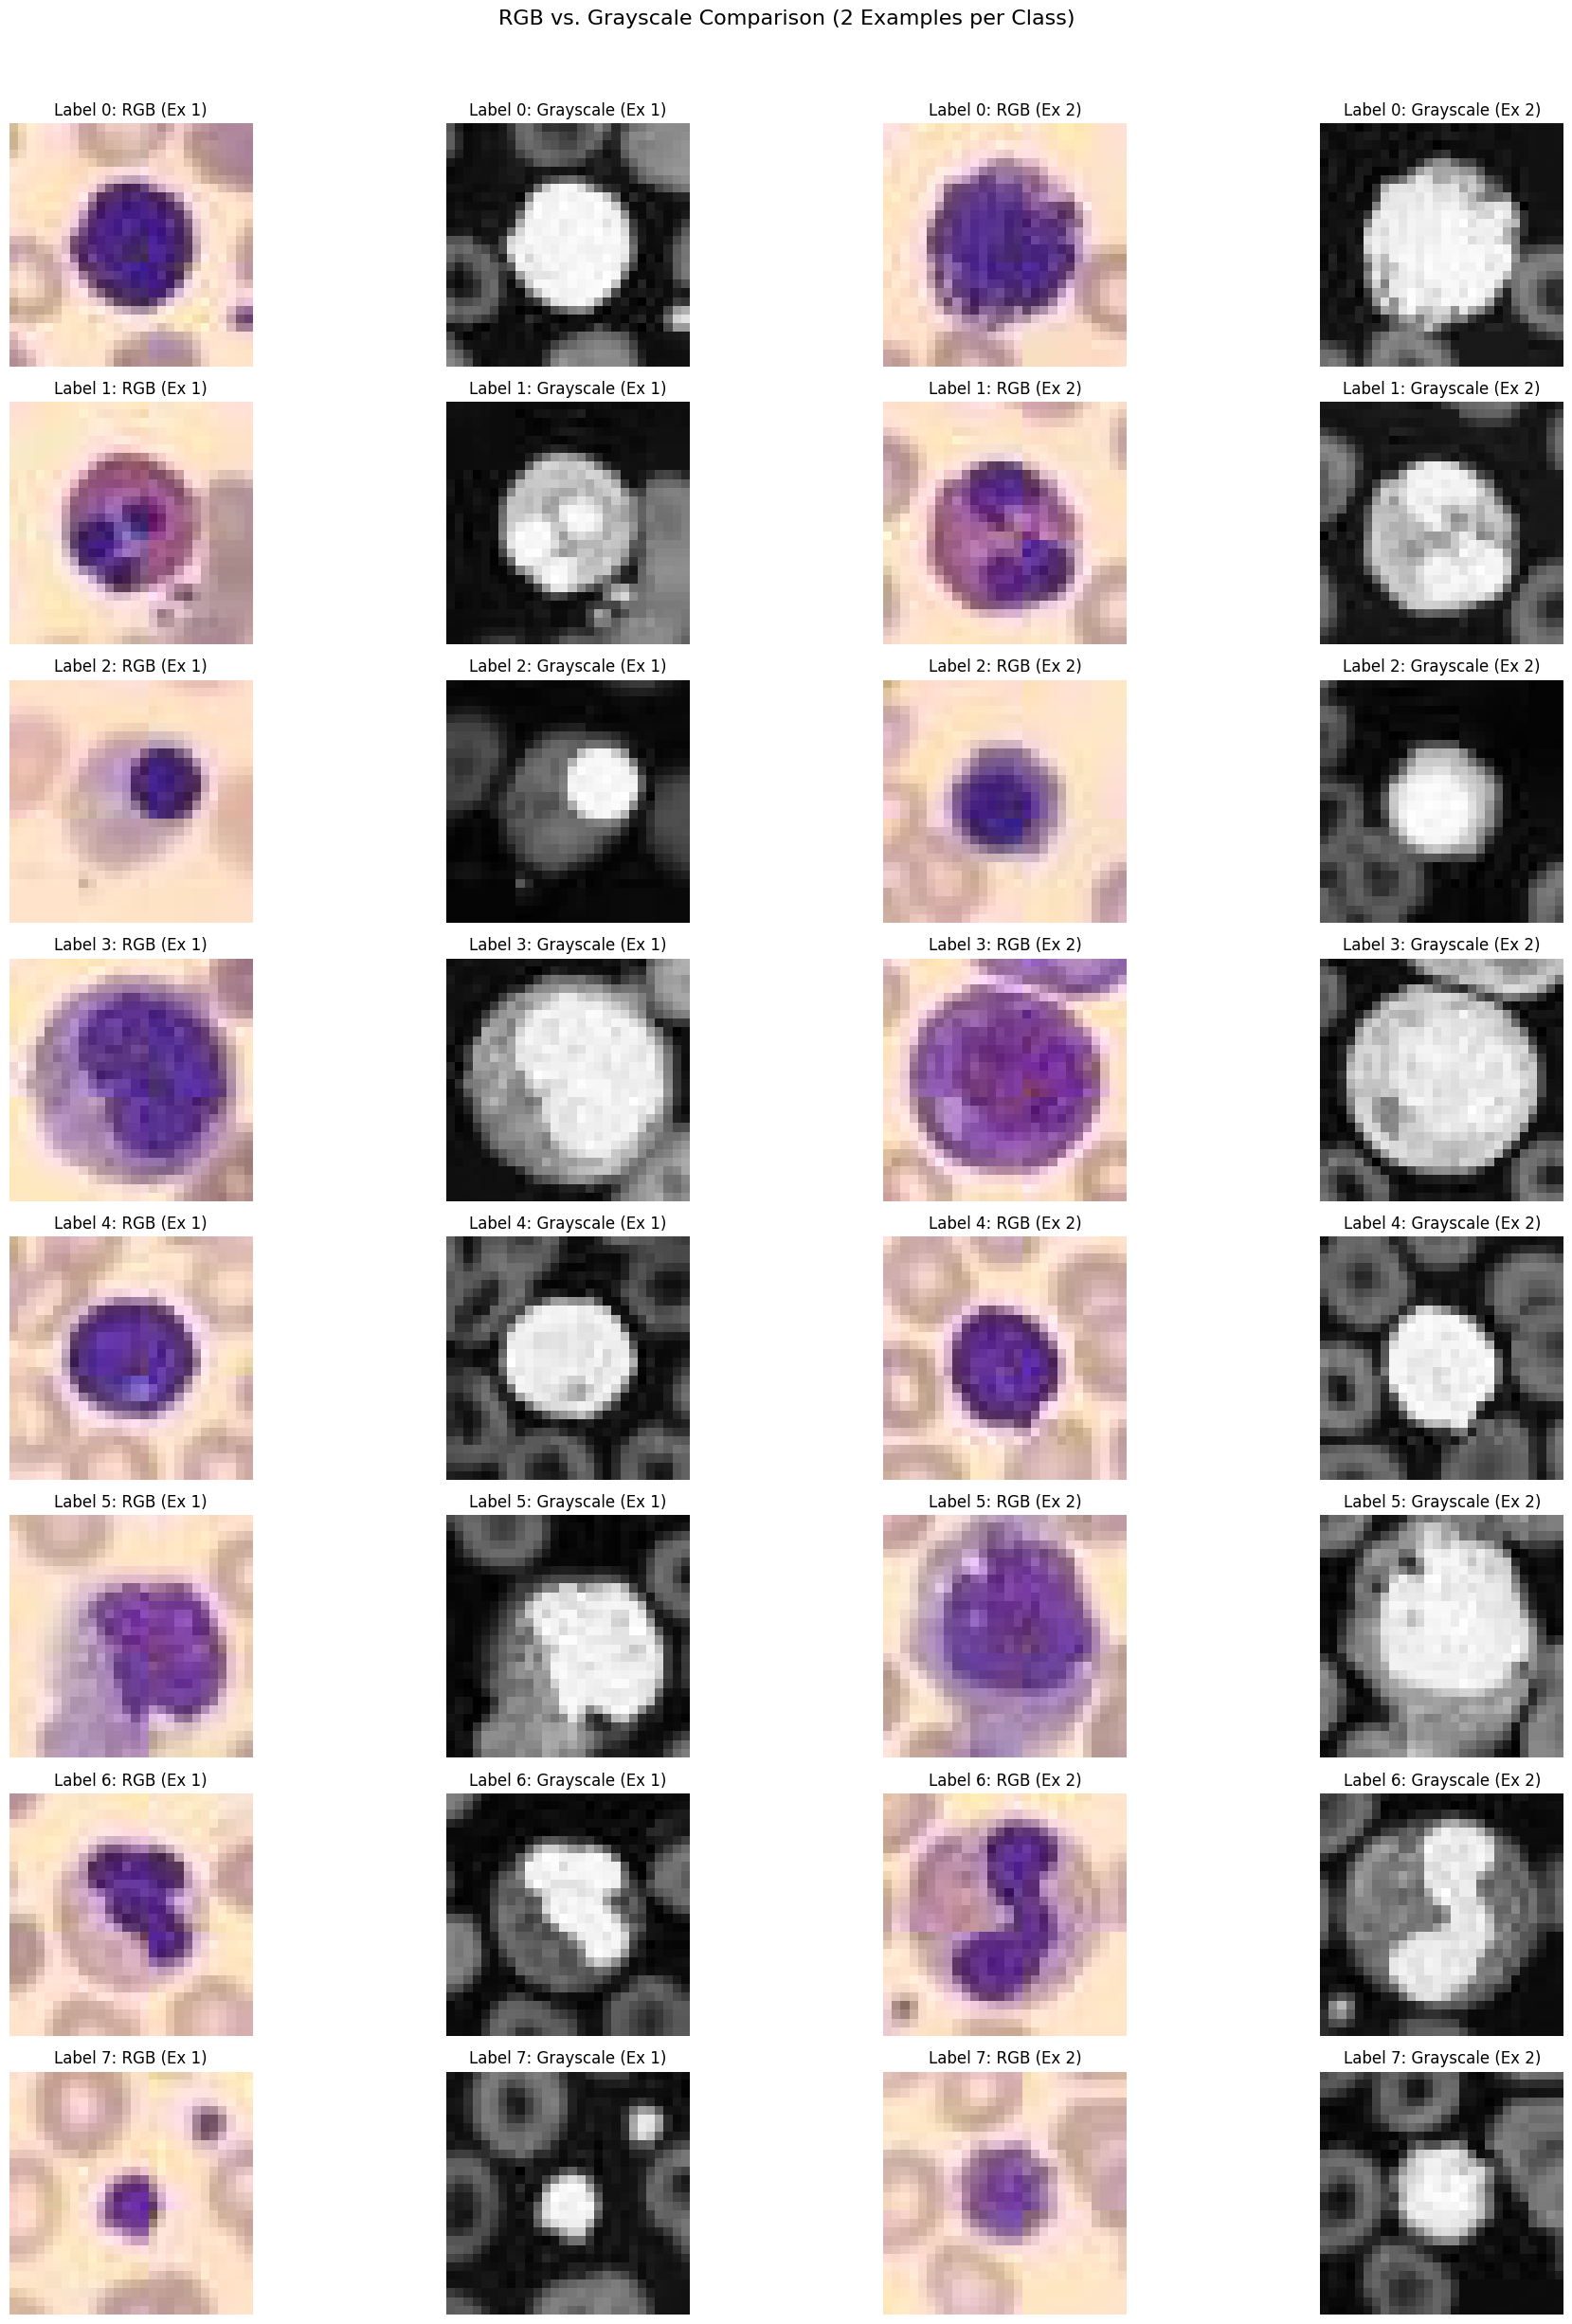

In [ ]:
#%% Show the images

labels = BloodMNIST_train_dataset.labels.squeeze()
unique_labels = np.unique(labels)
num_classes = len(unique_labels)

fig, axs = plt.subplots(
    nrows=num_classes, 
    ncols=4,            
    figsize=(20, num_classes * 3)
)

for row_idx, label in enumerate(unique_labels):
    indices = np.where(labels == label)[0][:2]  
    
    for col_offset, img_idx in enumerate(indices):
        ax_rgb = axs[row_idx, 2 * col_offset]
        ax_rgb.imshow(train_imgs[img_idx].numpy().astype('uint8'))
        ax_rgb.set_title(f"Label {label}: RGB (Ex {col_offset+1})", fontsize=12)
        ax_rgb.axis('off')
        
        ax_gray = axs[row_idx, 2 * col_offset + 1]
        ax_gray.imshow(train_gray[img_idx], cmap='Greys')
        ax_gray.set_title(f"Label {label}: Grayscale (Ex {col_offset+1})", fontsize=12)
        ax_gray.axis('off')

plt.suptitle("RGB vs. Grayscale Comparison (2 Examples per Class)", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# %% Create VAE and pipeline

image_pip = (dt.LoadImage(files.path) >> dt.NormalizeMinMax()
             >> dt.MoveAxis(2, 0) >> dt.pytorch.ToTensor(dtype=torch.float))
vae = dl.VariationalAutoEncoder(
    latent_dim=2, channels=[32,64],
    reconstruction_loss=torch.nn.BCELoss(reduction="sum"), beta=1,
).create()

train_dataset = dt.pytorch.Dataset(image_pip & image_pip, inputs=train_gray_source)
train_loader = dl.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
#%% Training

#vae = vae.to(device)
vae_trainer = dl.Trainer(max_epochs=50, accelerator="auto")
vae_trainer.fit(vae, train_loader)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 55.7 K | train
1 | fc_mu               | Linear                 | 6.3 K  | train
2 | fc_var              | Linear                 | 6.3 K  | train
3 | fc_dec              | Linear                 | 9.4 K  | train
4 | decoder             | ConvolutionalDecoder2d | 76.3 K | train
5 | reconstruction_loss | BCELoss                | 0      | train
6 | train_metrics       | MetricCollection       | 0      | train
7 | val_metrics         | MetricCollection       | 0      | train
8 | test_metrics        | MetricCollection       | 0      | train
9 | optimizer           | Adam                   |

Training: |          | 0/? [00:00<?, ?it/s]

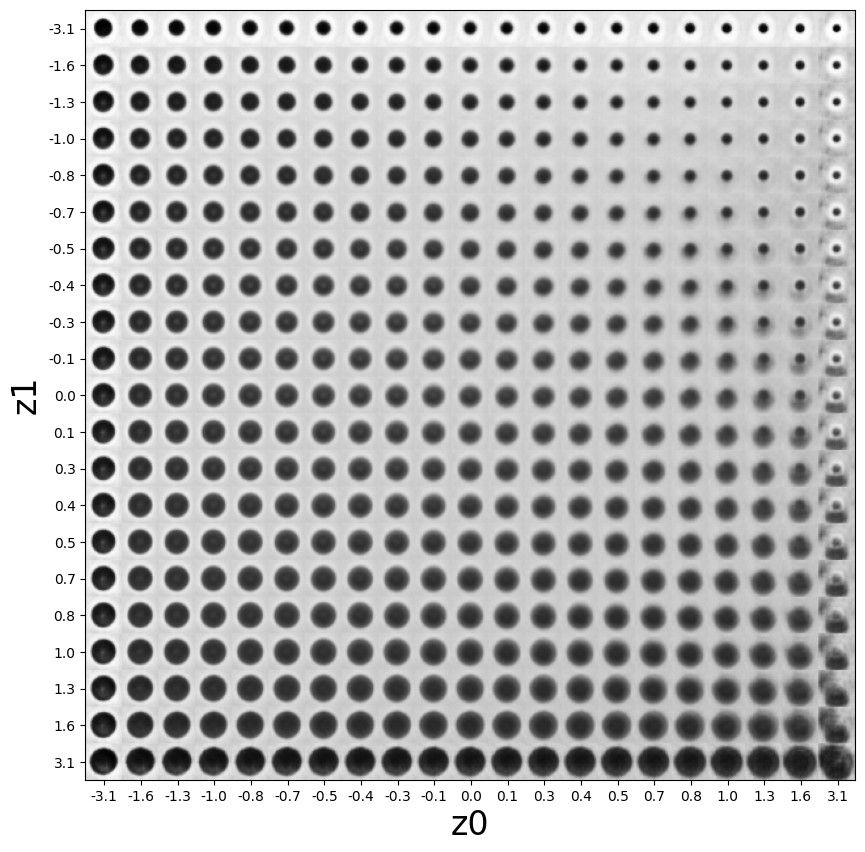

In [ ]:
# %% Generate images

img_num, img_size = 21, 28
z0_grid = z1_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))

image = np.zeros((img_num * img_size, img_num * img_size))
for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
      z = torch.stack((z0, z1)).unsqueeze(0)
      generated_image = vae.decode(z).clone().detach()
      image[i1 * img_size : (i1 + 1) * img_size,
            i0 * img_size : (i0 + 1) * img_size] = \
          generated_image.numpy().squeeze()

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
plt.xlabel("z0", fontsize=24)
plt.xticks(np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
           np.round(z0_grid.numpy(), 1))
plt.ylabel("z1", fontsize=24)
plt.yticks(np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
           np.round(z1_grid.numpy(), 1))
plt.show()

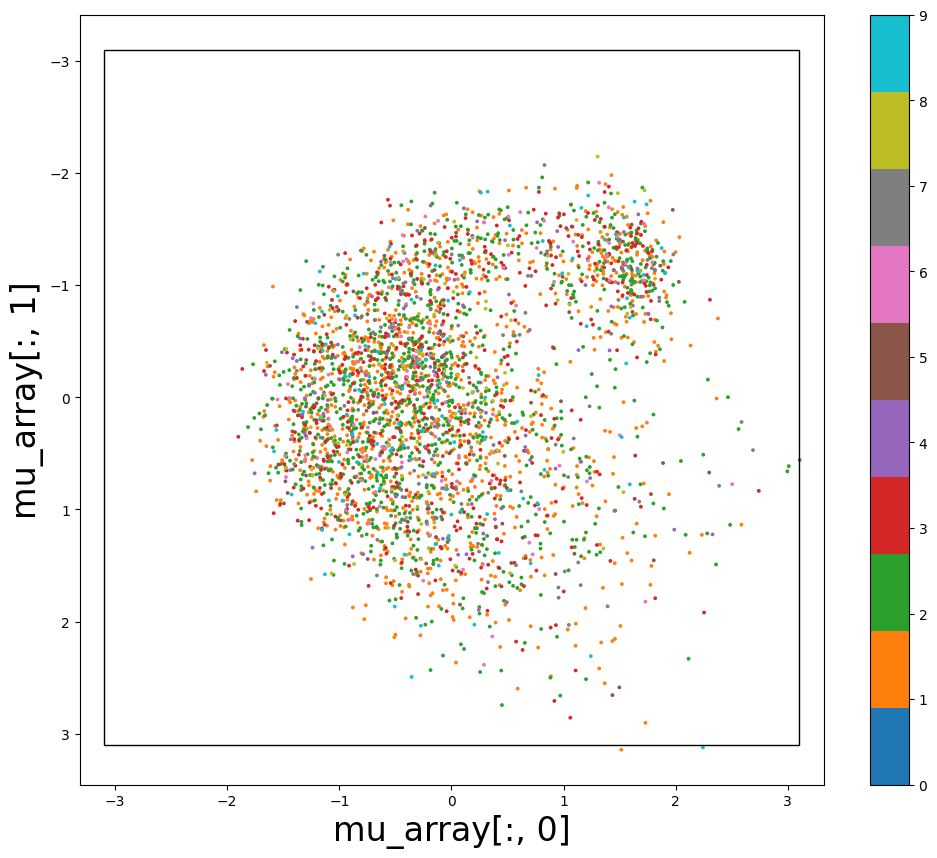

In [ ]:
#%% Latent space

label_pip = dt.Value(files.label_name[0]) >> int
test_dataset = dt.pytorch.Dataset(image_pip & label_pip, inputs=test_gray_source)
test_loader = dl.DataLoader(test_dataset, batch_size=64, shuffle=False)
mu_list, test_labels = [], []
for image, label in test_loader:
    mu, _ = vae.encode(image)
    mu_list.append(mu)
    test_labels.append(label)
mu_array = torch.cat(mu_list, dim=0).detach().numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()
plt.figure(figsize=(12, 10))
plt.scatter(mu_array[:, 0], mu_array[:, 1], s=3, c=test_labels, cmap="tab10")
plt.gca().add_patch(Rectangle((-3.1, -3.1), 6.2, 6.2, fc="none", ec="k", lw=1))
plt.xlabel("mu_array[:, 0]", fontsize=24)
plt.ylabel("mu_array[:, 1]", fontsize=24)
plt.gca().invert_yaxis()
plt.axis("equal")
plt.colorbar()
plt.show()